In [1]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import vtk as vtk

In [2]:
%matplotlib widget

In [3]:
pv.Report()

--------------------------------------------------------------------------------
  Date: Wed Feb 23 22:33:41 2022 Paris, Madrid

                OS : Windows
            CPU(s) : 8
           Machine : AMD64
      Architecture : 64bit
               RAM : 7.8 GiB
       Environment : Jupyter
        GPU Vendor : Intel
      GPU Renderer : Intel(R) UHD Graphics
       GPU Version : 4.5.0 - Build 26.20.100.7584

  Python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]

           pyvista : 0.33.dev0
               vtk : 9.1.0
             numpy : 1.20.1
           imageio : 2.9.0
           appdirs : 1.4.4
            scooby : 0.5.7
        matplotlib : 3.3.4
             PyQt5 : 5.9.2
           IPython : 7.22.0
        ipyvtklink : 0.2.1
             scipy : 1.6.2
              tqdm : 4.59.0
            meshio : 4.4.6

  Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

In [4]:
def gradients_to_dict(arr):
    keys = np.array(["dux/dx", "dux/dy", "dux/dz", "duy/dx", "duy/dy", "duy/dz", "duz/dx", "duz/dy", "duz/dz"])
    keys = keys.reshape((3,3))[:,:arr.shape[1]].ravel()
    return dict(zip(keys, arr.T))

def gradients_to_dict2(arr):
    keys = np.array(["dU/dx", "dU/dy", "dU/dz"])
    keys = keys.reshape((3,1))[:,:arr.shape[1]].ravel()
    return dict(zip(keys, arr.T))

def vorticity_to_dict(arr):
    keys = np.array(["vort_x", "vort_y", "vort_z"])
    keys = keys.reshape((3,1))[:,:arr.shape[1]].ravel()
    return dict(zip(keys, arr.T))

### Table of Contents

* [Reading the OpenFOAM file](#chapter1)
    * [Using pv.read](#section_1_1)
    * [Using pv.OpenFOAMReader](#section_1_2)
    
* [Velocity gradients at the lower wall patch](#chapter2)
* [Plotting](#chapter3)
    * [showing the mesh](#section_3_1)
    * [Plot a scalar field](#section_3_2)
    * [plot a scalar field with the mesh superposed](#section_3_8)
    * [Ploting the velocity using glyphs](#section_3_3)
    * [Ploting a scalar over a line](#section_3_4)
    * [Ploting a scalar over an arc ](#section_3_5)
    * [Ploting steamlines ](#section_3_6)
    * [Ploting gradients components](#section_3_7)
    
* [Fields](#chapter4)
    * [k field](#section_4_1)
    * [Epsilon field](#section_4_2)
    * [Nut field](#section_4_3)
    * [Pressure field](#section_4_4)
    
* [Skin friction velocity](#chapter4)
* [wall shear stress](#chapter5)


<a class="anchor" id="section_1_1"></a>

# Try to load case with pyvista.read

PyVista is smart enough to allow the load of an OpenFOAM case (.foam extension here)

In [5]:
# Import the OpenFOAM example case
case = pv.read("C:/Users/pret/Desktop/INSA HDF 5A/PLP 5A/OpenFOAM_example_case/case.foam")

In [6]:
case.keys()

['internalMesh']

In [7]:
mesh = case[0]

In [8]:
mesh

UnstructuredGrid (0x2bdb0afe8e0)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	10

* It looks like the number of arrays is doubled here, there is 2 times the `Data Arrays`.
* It looks like the case is loaded for `time=0`.

Here is for example below the U field where it's 0 everywhere expect at the inlet which is the intial condtion at `time=0`.

In [9]:
 mesh.plot(scalars='U',cpos='xy')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

A Jupyter widget could not be displayed because the widget state could not be found. This could happen if the kernel storing the widget is no longer available, or if the widget state was not saved in the notebook. You may be able to create the widget by running the appropriate cells.


<a class="anchor" id="section_1_2"></a>

# Load the case with `OpenFOAMReader`

In [10]:
reader = pv.OpenFOAMReader("C:/Users/pret/Desktop/INSA HDF 5A/PLP 5A/OpenFOAM_example_case/case.foam")
reader.cell_to_point_creation = False
# When set to True, copies cell data and creates point data from it. Vector and tensor norms (like U-normed) are in point data
# When set to False, only cell data is read
time = reader.time_values
print(time)

[0.0, 500.0, 1000.0]


In [11]:
reader.enable_all_patch_arrays() # enables all the patches, including the boundaries
reader.set_active_time_value(time[1]) # set time at whichever value we want to visualise
multi_block = reader.read()
print(multi_block.keys())
multi_block 

['internalMesh', 'boundary']


MultiBlock (0x2bda7b65520)
  N Blocks:	2
  X Bounds:	-0.021, 0.290
  Y Bounds:	-0.025, 0.025
  Z Bounds:	-0.001, 0.001

In [12]:
internalMesh = multi_block[0]
internalMesh

UnstructuredGrid (0x2bdb882fb20)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

In [13]:
boundary = multi_block[1]
boundary

MultiBlock (0x2bdb84e2160)
  N Blocks:	5
  X Bounds:	-0.021, 0.290
  Y Bounds:	-0.025, 0.025
  Z Bounds:	-0.001, 0.001

In [14]:
boundary[2]

PolyData (0x2bdb0afe640)
  N Cells:	223
  N Points:	448
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	1.660e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

In [15]:
merged = boundary.combine(merge_points=False, tolerance=0.0)
# this allows us to combine all the boundaries together in one UnstructuredGrid
fullMesh = internalMesh.merge(merged, merge_points=True, inplace=False, main_has_priority=False, progress_bar=False)
# this allows us to get one complete mesh that contains both the internalMesh and the boundaries
fullMesh

UnstructuredGrid (0x2bdb84e29a0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

# Two datasets : cell data and point data

Let's create two datasets: one that only contains the cell data and one that only contains the point data. The datasets will be derived from the `fullMesh`

In [16]:
mesh_cell = fullMesh
mesh_point = mesh_cell.cell_data_to_point_data()
mesh_cell

UnstructuredGrid (0x2bdb84e29a0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

In [17]:
mesh_point

UnstructuredGrid (0x2bdb84e2880)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

# Show the mesh 

In [18]:
# Create a plotting object to display vtk meshes or numpy arrays
p = pv.Plotter()
# Show the mesh in wireframe style
p.add_mesh(fullMesh, style="wireframe", color="w")
# View in the xy plane
p.view_xy()
# Show the axes
p.add_axes()
# Display the plotting window
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="section_3_2"></a>

# Plot the velocity field


In [19]:
p2 = pv.Plotter()
p2.add_mesh(mesh_cell ,scalars='U', show_edges=False)
# if show_edges is set to True, the mesh will be surimposed on the domain
p2.view_xy()
p2.add_axes()
p2.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [20]:
p3 = pv.Plotter()
p3.add_mesh(mesh_point ,scalars='U', show_edges=False)
# if show_edges is set to True, the mesh will be surimposed on the domain
p3.view_xy()
p3.add_axes()
p3.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="section_3_3"></a>

# Plot the velocity field using glyphs

In [21]:
geom = pv.Arrow()
glyphs = mesh_cell.glyph(orient='U',scale='U-normed',factor=0.0005,geom=geom)
# we can scale our vectors with the scale function.
# when set to True, it uses the active scalars to scale the glyphs. The scaling vectors can also be specified by the user
# when set to False, the glyphs won't be scaled
p4 = pv.Plotter()
p4.add_mesh(glyphs)
p4.view_xy()
p4.add_axes()
p4.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [22]:
geom = pv.Arrow()
glyphs = mesh_point.glyph(orient='U',scale=False,factor=0.002,geom=geom)
# we can scale our vectors with the scale function.
# when set to True, it uses the active scalars to scale the glyphs. The scaling vectors can also be specified by the user
# when set to False, the glyphs won't be scaled
p5 = pv.Plotter()
p5.add_mesh(glyphs)
p5.view_xy()
p5.add_axes()
p5.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Plot over line example

In [23]:
# Create the 2 points defining the line
A = [0, -0.015, 0]
B = [fullMesh.bounds[1], -0.015, 0]

# Create a Line object
line = pv.Line(A, B)

Let's show the line in the computational domain

In [24]:
p6 = pv.Plotter()
p6.add_mesh(mesh_point, style="wireframe", color='white')
# Show the line in red in the domain
p6.add_mesh(line, color="r", line_width=5)
p6.view_xy()
p6.add_axes()
p6.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Let's make a plot overline :

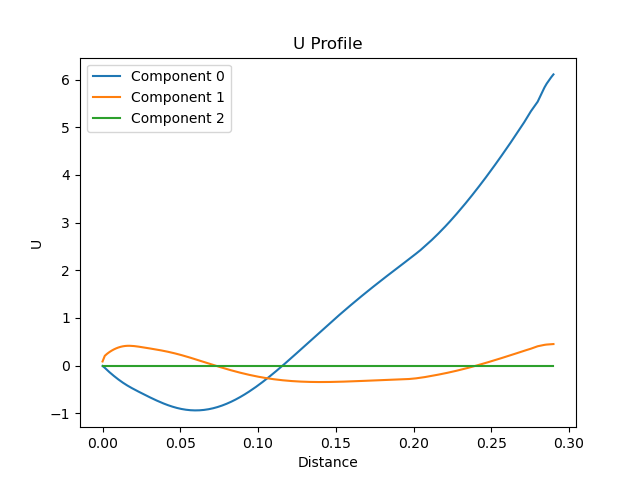

In [25]:
mesh_point.plot_over_line(A, B, resolution=200, scalars='U')

### How to access the vector components

In [26]:
mesh_cell.cell_data

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : U-normed
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32  (37235, 3)           VECTORS
    epsilon                 float32  (37235,)
    k                       float32  (37235,)
    nut                     float32  (37235,)
    p                       float32  (37235,)
    U-normed                float32  (37235,)             SCALARS

In [27]:
ux = mesh_cell['U'][:,0]
uy = mesh_cell['U'][:,1]
uz = mesh_cell['U'][:,2]

mesh_cell.cell_data["ux"] = ux
mesh_cell.cell_data["uy"] = uy
mesh_cell.cell_data["uz"] = uz

mesh_cell

UnstructuredGrid (0x2bdb84e29a0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	9

In [28]:
mesh_point.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : U-normed
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32  (25012, 3)           VECTORS
    epsilon                 float32  (25012,)
    k                       float32  (25012,)
    nut                     float32  (25012,)
    p                       float32  (25012,)
    U-normed                float32  (25012,)             SCALARS

In [29]:
ux = mesh_point['U'][:,0]
uy = mesh_point['U'][:,1]
uz = mesh_point['U'][:,2]

mesh_point.point_data["ux"] = ux
mesh_point.point_data["uy"] = uy
mesh_point.point_data["uz"] = uz

mesh_point

UnstructuredGrid (0x2bdb84e2880)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	9

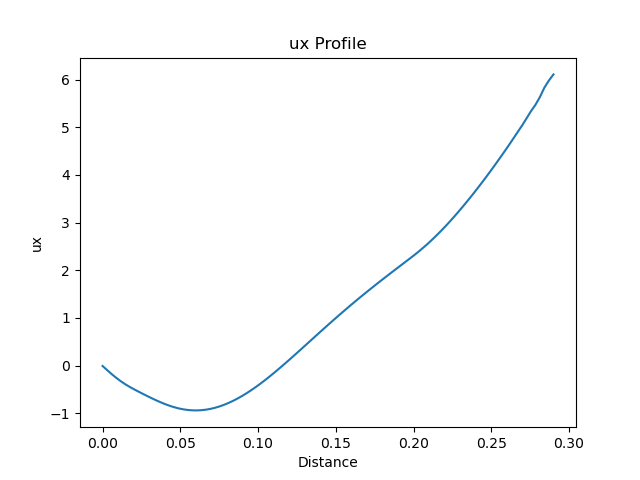

In [30]:
mesh_point.plot_over_line(A, B, resolution=100, scalars='ux')

# Plot a scalar over a circular arc

In [31]:
# Make two points at the bounds of the mesh and one at the center to
# construct a circular arc.
normal = [0, 0, 1]
polar = [0.02, 0, 0]
center = [0, 0, 0]
angle = 100.0

# Preview how this circular arc intersects this mesh
arc = pv.CircularArcFromNormal(center, 100, normal, polar, angle)

Let's see what's in the arc object.

In [32]:
arc

PolyData (0x2bd893950a0)
  N Cells:	1
  N Points:	101
  X Bounds:	-3.473e-03, 2.000e-02
  Y Bounds:	0.000e+00, 2.000e-02
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	2

In [33]:
p7 = pv.Plotter()
p7.add_mesh(mesh_cell, style="wireframe", color="w")
p7.add_mesh(arc, color="r")
a = arc.points[0]
b = arc.points[-1]
p7.add_point_labels(
    [a, b], ["A", "B"], font_size=48, point_color="red", text_color="red"
)
p7.view_xy()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

I don't know how to add another plot on the same figure, it's perhaps only possible to plot one scalar or one vector at a time with this API.

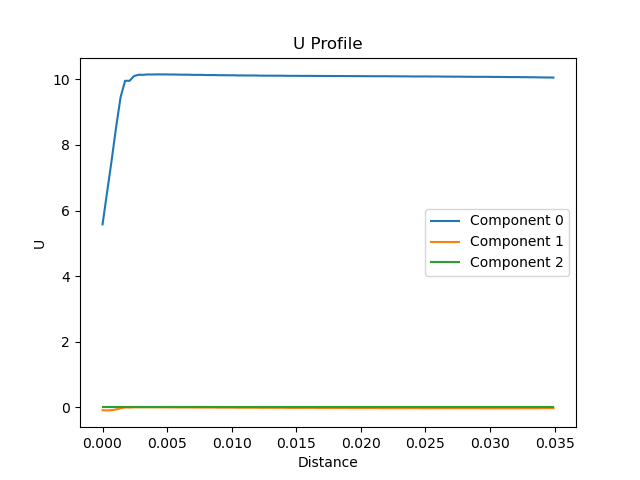

In [34]:
mesh_cell.plot_over_circular_arc_normal(center, 100, normal, polar, angle, scalars='U')
#mesh_cell.plot_over_circular_arc_normal(center, 100, normal, polar, angle, scalars='ux')
#mesh_cell.plot_over_circular_arc_normal(center, 100, normal, polar, angle, scalars='uy')

So let's try another way and create the figure ourself (there may be better ways to do this by the way).

In [35]:
sampled = pv.DataSetFilters.sample_over_circular_arc_normal(mesh_cell,center,100,normal,polar,angle)

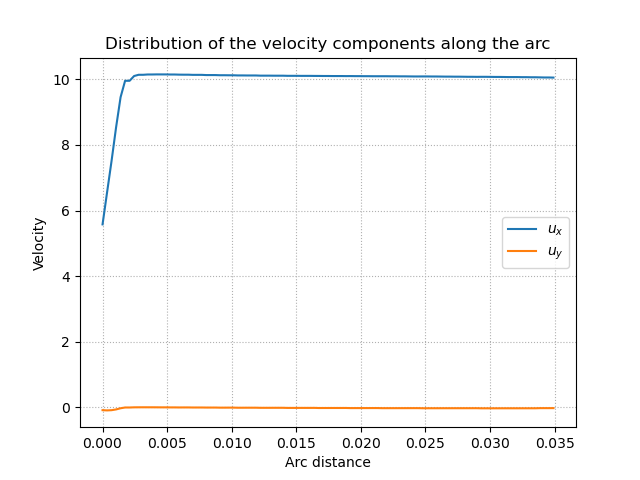

In [36]:
plt.figure()
plt.plot(sampled['Distance'],sampled['ux'],label='$u_x$')
plt.plot(sampled['Distance'],sampled['uy'],label='$u_y$')
plt.xlabel('Arc distance')
plt.ylabel('Velocity')
plt.title('Distribution of the velocity components along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [37]:
sampled = pv.DataSetFilters.sample_over_circular_arc_normal(mesh_point,center,100,normal,polar,angle)

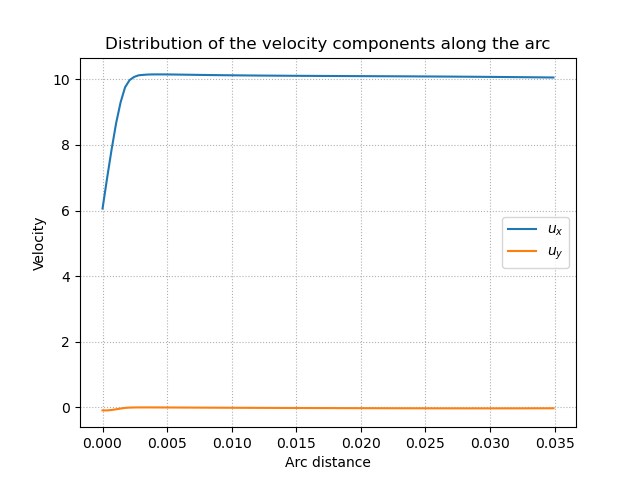

In [38]:
plt.figure()
plt.plot(sampled['Distance'],sampled['ux'],label='$u_x$')
plt.plot(sampled['Distance'],sampled['uy'],label='$u_y$')
plt.xlabel('Arc distance')
plt.ylabel('Velocity')
plt.title('Distribution of the velocity components along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

# Let's plot some other fields

## k field

In [39]:
### k field (cell data)
p8 = pv.Plotter()
p8.add_mesh(mesh_cell,scalars='k')
p8.view_xy()
p8.add_axes()
p8.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [40]:
### k field (point data)
p9 = pv.Plotter()
p9.add_mesh(mesh_point,scalars='k')
p9.view_xy()
p9.add_axes()
p9.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Epsilon field

In [41]:
### epsilon field (cell data)
p10 = pv.Plotter()
p10.add_mesh(mesh_cell,scalars='epsilon')
p10.view_xy()
p10.add_axes()
p10.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [42]:
### epsilon field (point data)
p11 = pv.Plotter()
p11.add_mesh(mesh_point,scalars='epsilon')
p11.view_xy()
p11.add_axes()
p11.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Nut Field

In [43]:
### nut field (cell data)
p12 = pv.Plotter()
p12.add_mesh(mesh_cell,scalars='nut')
p12.view_xy()
p12.add_axes()
p12.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [44]:
### nut field (point data)
p13 = pv.Plotter()
p13.add_mesh(mesh_point,scalars='nut')
p13.view_xy()
p13.add_axes()
p13.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Pressure field

In [45]:
### pressure field (cell data)
p14 = pv.Plotter()
p14.add_mesh(mesh_cell,scalars='p')
p14.view_xy()
p14.add_axes()
p14.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [46]:
### pressure field (point data)
p15 = pv.Plotter()
p15.add_mesh(mesh_point,scalars='p')
p15.view_xy()
p15.add_axes()
p15.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Let's plot the streamlines

In [47]:
X_center = (fullMesh.bounds[0]+fullMesh.bounds[1])/2
Y_center = (fullMesh.bounds[2]+fullMesh.bounds[3])/2
Z_center = (fullMesh.bounds[4]+fullMesh.bounds[5])/2
centers = [X_center, Y_center, Z_center] 

In [48]:
face = mesh_point.slice(normal='x') # "normal" should be set as the direction of the flow
slices = mesh_point.slice_along_axis(n=8, axis="x") # axis is the axis of the flow
faces = slices.combine() # converts Multiblock into UnstructuredGrid 

str1 = mesh_point.streamlines_from_source(faces, vectors='U') # streamlines using multiple surfaces
str2 = mesh_point.streamlines_from_source(face, vectors='U') # streamlines using a singular surface
# both require a dataset for the surface

str3 = mesh_point.streamlines( 
n_points=100,
vectors='U',
pointa=(mesh_cell.bounds[0], mesh_cell.bounds[2], centers[2]),
pointb=(mesh_cell.bounds[0], mesh_cell.bounds[3], centers[2])
)  # Streamlines using a line

In [49]:
# Streamlines obtained from one singular surface
p16 = pv.Plotter()
p16.add_mesh(mesh_point, color="w")
p16.add_mesh(str2.tube(radius=0.0004))
# View in the xy plane
p16.view_xy()
# Show the axes
p16.add_axes()
# Display the plotting window
p16.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

It seems this only works with `mesh_point` and not with `mesh_cell`

# Let's determine the gradients and vorticity 

In [50]:
# deriv will contain the data from the gradient of U (9 components)
deriv_cell = mesh_cell.compute_derivative(scalars='U', gradient=True, divergence=None, vorticity=True, 
                                          qcriterion=None, faster=False, preference='cell', progress_bar=False)
# deriv2 will contain the data from the gradient of U-normed (3 components)
deriv2_cell = mesh_cell.compute_derivative(scalars="U-normed", gradient=True, divergence=None, vorticity=False, 
                                          qcriterion=None, faster=False, preference='cell', progress_bar=False)

In [51]:
grad_cell = gradients_to_dict(deriv_cell["gradient"])
grad2_cell = gradients_to_dict2(deriv2_cell["gradient"])
vort_cell = vorticity_to_dict(deriv_cell["vorticity"])

mesh_cell.cell_data["dU/dx"] = grad2_cell["dU/dx"]
mesh_cell.cell_data["dU/dy"] = grad2_cell["dU/dy"]
mesh_cell.cell_data["dU/dz"] = grad2_cell["dU/dz"]
mesh_cell.cell_data["dux/dx"] = grad_cell["dux/dx"]
mesh_cell.cell_data["dux/dy"] = grad_cell["dux/dy"]
mesh_cell.cell_data["dux/dz"] = grad_cell["dux/dz"]
mesh_cell.cell_data["duy/dx"] = grad_cell["duy/dx"]
mesh_cell.cell_data["duy/dy"] = grad_cell["duy/dy"]
mesh_cell.cell_data["duy/dz"] = grad_cell["duy/dz"]
mesh_cell.cell_data["duz/dx"] = grad_cell["duz/dx"]
mesh_cell.cell_data["duz/dy"] = grad_cell["duz/dy"]
mesh_cell.cell_data["duz/dz"] = grad_cell["duz/dz"]
mesh_cell.cell_data["vort_x"] = vort_cell["vort_x"]
mesh_cell.cell_data["vort_y"] = vort_cell["vort_y"]
mesh_cell.cell_data["vort_z"] = vort_cell["vort_z"]

mesh_cell

UnstructuredGrid (0x2bdb84e29a0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	24

In [52]:
# deriv will contain the data from the gradient of U (9 components)
deriv_point = mesh_point.compute_derivative(scalars='U', gradient=True, divergence=None, vorticity=True, 
                                          qcriterion=None, faster=False, preference='point', progress_bar=False)
# deriv2 will contain the data from the gradient of U-normed (3 components)
deriv2_point = mesh_point.compute_derivative(scalars="U-normed", gradient=True, divergence=None, vorticity=False, 
                                          qcriterion=None, faster=False, preference='cell', progress_bar=False)

In [53]:
grad_point = gradients_to_dict(deriv_point["gradient"])
grad2_point = gradients_to_dict2(deriv2_point["gradient"])
vort_point = vorticity_to_dict(deriv_point["vorticity"])

mesh_point.point_data["dU/dx"] = grad2_point["dU/dx"]
mesh_point.point_data["dU/dy"] = grad2_point["dU/dy"]
mesh_point.point_data["dU/dz"] = grad2_point["dU/dz"]
mesh_point.point_data["dux/dx"] = grad_point["dux/dx"]
mesh_point.point_data["dux/dy"] = grad_point["dux/dy"]
mesh_point.point_data["dux/dz"] = grad_point["dux/dz"]
mesh_point.point_data["duy/dx"] = grad_point["duy/dx"]
mesh_point.point_data["duy/dy"] = grad_point["duy/dy"]
mesh_point.point_data["duy/dz"] = grad_point["duy/dz"]
mesh_point.point_data["duz/dx"] = grad_point["duz/dx"]
mesh_point.point_data["duz/dy"] = grad_point["duz/dy"]
mesh_point.point_data["duz/dz"] = grad_point["duz/dz"]
mesh_point.point_data["vort_x"] = vort_point["vort_x"]
mesh_point.point_data["vort_y"] = vort_point["vort_y"]
mesh_point.point_data["vort_z"] = vort_point["vort_z"]

mesh_point

UnstructuredGrid (0x2bdb84e2880)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	24

## Let's plot gradient components 

In [54]:
### multiplot, plotting all the gradient components 
### {du/dx, du/dy, du/dz, dv/dx, dv/dy, dv/dz, dw/dx, dw/dy, dw/dz}

plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx", font_size=20)
plotter.add_mesh(mesh_cell,scalars="dux/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [55]:
### multiplot, plotting all the gradient components 
### {du/dx, du/dy, du/dz, dv/dx, dv/dy, dv/dz, dw/dx, dw/dy, dw/dz}

plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx", font_size=20)
plotter.add_mesh(mesh_point,scalars="dux/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Let's plot vorticity components

In [56]:
### multiplot, plotting of vorticity components (cell data)

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x", font_size=20)
plotter.add_mesh(mesh_cell,scalars="vort_x")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="vort_y")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="vort_z")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [57]:
### multiplot, plotting of vorticity components (point data)

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x", font_size=20)
plotter.add_mesh(mesh_point,scalars="vort_x")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="vort_y")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="vort_z")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Vectors normalization compared to the maximal component 

In [58]:
duxdx_norm=(mesh_cell["dux/dx"]-min(mesh_cell["dux/dx"]))/(max(mesh_cell["dux/dx"])-min(mesh_cell["dux/dx"]))
duydx_norm=(mesh_cell["duy/dx"]-min(mesh_cell["duy/dx"]))/(max(mesh_cell["duy/dx"])-min(mesh_cell["duy/dx"]))
duzdx_norm=(mesh_cell["duz/dx"]-min(mesh_cell["duz/dx"]))/(max(mesh_cell["duz/dx"])-min(mesh_cell["duz/dx"]))
duxdy_norm=(mesh_cell["dux/dy"]-min(mesh_cell["dux/dy"]))/(max(mesh_cell["dux/dy"])-min(mesh_cell["dux/dy"]))
duydy_norm=(mesh_cell["duy/dy"]-min(mesh_cell["duy/dy"]))/(max(mesh_cell["duy/dy"])-min(mesh_cell["duy/dy"]))
duzdy_norm=(mesh_cell["duz/dy"]-min(mesh_cell["duz/dy"]))/(max(mesh_cell["duz/dy"])-min(mesh_cell["duz/dy"]))
#duxdz_norm=(mesh_cell["dux/dz"]-min(mesh_cell["dux/dz"]))/(max(mesh_cell["dux/dz"])-min(mesh_cell["dux/dz"]))
#duydz_norm=(mesh_cell["duy/dz"]-min(mesh_cell["duy/dz"]))/(max(mesh_cell["duy/dz"])-min(mesh_cell["duy/dz"]))
#duzdz_norm=(mesh_cell["duz/dz"]-min(mesh_cell["duz/dz"]))/(max(mesh_cell["duz/dz"])-min(mesh_cell["duz/dz"]))
vort_x_norm=(mesh_cell["vort_x"]-min(mesh_cell["vort_x"]))/(max(mesh_cell["vort_x"])-min(mesh_cell["vort_x"]))
vort_y_norm=(mesh_cell["vort_y"]-min(mesh_cell["vort_y"]))/(max(mesh_cell["vort_y"])-min(mesh_cell["vort_y"]))
vort_z_norm=(mesh_cell["vort_z"]-min(mesh_cell["vort_z"]))/(max(mesh_cell["vort_z"])-min(mesh_cell["vort_z"]))

We have to add these data to the `mesh_cell` available fields if we want to plot them. Otherwise, their names would be "Data" (see last attempt with "a").

In [59]:
mesh_cell.cell_data["dux/dx n"] = duxdx_norm
mesh_cell.cell_data["duy/dx n"] = duydx_norm
mesh_cell.cell_data["duz/dx n"] = duzdx_norm
mesh_cell.cell_data["dux/dy n"] = duxdy_norm
mesh_cell.cell_data["duy/dy n"] = duydy_norm
mesh_cell.cell_data["duz/dy n"] = duzdy_norm
#mesh_cell.cell_data["dux/dz n"] = duxdz_norm
#mesh_cell.cell_data["duy/dz n"] = duydz_norm
#mesh_cell.cell_data["duz/dz n"] = duzdz_norm
mesh_cell.cell_data["vort_x n"] = vort_x_norm
mesh_cell.cell_data["vort_y n"] = vort_y_norm
mesh_cell.cell_data["vort_z n"] = vort_z_norm

Be careful: 0 division in the case of z gradient components 

In [60]:
mesh_cell

UnstructuredGrid (0x2bdb84e29a0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	33

In [61]:
#plot
plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx n", font_size=20)
plotter.add_mesh(mesh_cell,scalars='dux/dx n')
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [62]:
### multiplot

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x n", font_size=20)
plotter.add_mesh(mesh_cell,scalars="vort_x n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="vort_y n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="vort_z n")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [63]:
duxdx_norm=(mesh_point["dux/dx"]-min(mesh_point["dux/dx"]))/(max(mesh_point["dux/dx"])-min(mesh_point["dux/dx"]))
duydx_norm=(mesh_point["duy/dx"]-min(mesh_point["duy/dx"]))/(max(mesh_point["duy/dx"])-min(mesh_point["duy/dx"]))
duzdx_norm=(mesh_point["duz/dx"]-min(mesh_point["duz/dx"]))/(max(mesh_point["duz/dx"])-min(mesh_point["duz/dx"]))
duxdy_norm=(mesh_point["dux/dy"]-min(mesh_point["dux/dy"]))/(max(mesh_point["dux/dy"])-min(mesh_point["dux/dy"]))
duydy_norm=(mesh_point["duy/dy"]-min(mesh_point["duy/dy"]))/(max(mesh_point["duy/dy"])-min(mesh_point["duy/dy"]))
duzdy_norm=(mesh_point["duz/dy"]-min(mesh_point["duz/dy"]))/(max(mesh_point["duz/dy"])-min(mesh_point["duz/dy"]))
#duxdz_norm=(mesh_point["dux/dz"]-min(mesh_point["dux/dz"]))/(max(mesh_point["dux/dz"])-min(mesh_point["dux/dz"]))
#duydz_norm=(mesh_point["duy/dz"]-min(mesh_point["duy/dz"]))/(max(mesh_point["duy/dz"])-min(mesh_point["duy/dz"]))
#duzdz_norm=(mesh_point["duz/dz"]-min(mesh_point["duz/dz"]))/(max(mesh_point["duz/dz"])-min(mesh_point["duz/dz"]))
vort_x_norm=(mesh_point["vort_x"]-min(mesh_point["vort_x"]))/(max(mesh_point["vort_x"])-min(mesh_point["vort_x"]))
vort_y_norm=(mesh_point["vort_y"]-min(mesh_point["vort_y"]))/(max(mesh_point["vort_y"])-min(mesh_point["vort_y"]))
vort_z_norm=(mesh_point["vort_z"]-min(mesh_point["vort_z"]))/(max(mesh_point["vort_z"])-min(mesh_point["vort_z"]))

In [64]:
mesh_point.point_data["dux/dx n"] = duxdx_norm
mesh_point.point_data["duy/dx n"] = duydx_norm
mesh_point.point_data["duz/dx n"] = duzdx_norm
mesh_point.point_data["dux/dy n"] = duxdy_norm
mesh_point.point_data["duy/dy n"] = duydy_norm
mesh_point.point_data["duz/dy n"] = duzdy_norm
#mesh_point.point_data["dux/dz n"] = duxdz_norm
#mesh_point.point_data["duy/dz n"] = duydz_norm
#mesh_point.point_data["duz/dz n"] = duzdz_norm
mesh_point.point_data["vort_x n"] = vort_x_norm
mesh_point.point_data["vort_y n"] = vort_y_norm
mesh_point.point_data["vort_z n"] = vort_z_norm

In [65]:
mesh_point

UnstructuredGrid (0x2bdb84e2880)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	33

In [66]:
#plot
plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx n", font_size=20)
plotter.add_mesh(mesh_point,scalars='dux/dx n')
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="chapter5"></a>

In [67]:
### multiplot

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x n", font_size=20)
plotter.add_mesh(mesh_point,scalars="vort_x n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="vort_y n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="vort_z n")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Wall shear stress

This part requires an updated version of PyVista.

In the Anaconda prompt, please type "conda install git" and execute.

Then, in the cell just below, copy paste and execute this instruction: 

pip install git+https://github.com/pyvista/pyvista.git@refs/pull/1896/head

(Be aware of having the administrator rights in both cases)

In [68]:
#pip install git+https://github.com/pyvista/pyvista.git@refs/pull/1896/head

In [69]:
#pdt_scal=np.dot(lower_wall_point.point_data["dux/dy"],lower_wall_point.point_data["Normals"])
#lower_wall_point.point_data["dux/dy"].shape
#pdt_scal

In [70]:
#visc=18.5e-6
#wss=visc*pdt_scal
#lower_wall_point.add_field_data(wss, 'wss')
#lower_wall_point

## Let's get the gradients at one of the patches

In [71]:
#lower_wall_cell = lower_wall_cell.compute_derivative(scalars="U")
#lower_wall_cell

In [72]:
# deriv will contain the data from the gradient of U (9 components)
#deriv_cell = lower_wall_cell.compute_derivative(scalars="U")

#grad_cell = gradients_to_dict(deriv_cell["gradient"])

#lower_wall_cell.cell_data["dux/dx"] = grad_cell["dux/dx"]
#lower_wall_cell.cell_data["dux/dy"] = grad_cell["dux/dy"]
#lower_wall_cell.cell_data["dux/dz"] = grad_cell["dux/dz"]
#lower_wall_cell.cell_data["duy/dx"] = grad_cell["duy/dx"]
#lower_wall_cell.cell_data["duy/dy"] = grad_cell["duy/dy"]
#lower_wall_cell.cell_data["duy/dz"] = grad_cell["duy/dz"]
#lower_wall_cell.cell_data["duz/dx"] = grad_cell["duz/dx"]
#lower_wall_cell.cell_data["duz/dy"] = grad_cell["duz/dy"]
#lower_wall_cell.cell_data["duz/dz"] = grad_cell["duz/dz"]

#lower_wall_cell

In [73]:
#lower_wall_point = lower_wall_point.compute_derivative(scalars="U")
#lower_wall_point

In [74]:
# deriv will contain the data from the gradient of U (9 components)
#deriv_point = lower_wall_point.compute_derivative(scalars="U")

#grad_point = gradients_to_dict(deriv_point["gradient"])

#lower_wall_point.point_data["dux/dx"] = grad_point["dux/dx"]
#lower_wall_point.point_data["dux/dy"] = grad_point["dux/dy"]
#lower_wall_point.point_data["dux/dz"] = grad_point["dux/dz"]
#lower_wall_point.point_data["duy/dx"] = grad_point["duy/dx"]
#lower_wall_point.point_data["duy/dy"] = grad_point["duy/dy"]
#lower_wall_point.point_data["duy/dz"] = grad_point["duy/dz"]
#lower_wall_point.point_data["duz/dx"] = grad_point["duz/dx"]
#lower_wall_point.point_data["duz/dy"] = grad_point["duz/dy"]
#lower_wall_point.point_data["duz/dz"] = grad_point["duz/dz"]

#lower_wall_point

In [75]:
#lower_wall_cell= lower_wall_cell.compute_normals()
#normals_cell = lower_wall_cell.active_normals
#normals_cell.shape

In [76]:
#lower_wall_cell

In [77]:
#lower_wall_point= lower_wall_point.compute_normals()
#normals_point = lower_wall_point.active_normals
#normals_point.shape

In [78]:
#lower_wall_point.clear_cell_data()
#lower_wall_point

In [79]:
data_line = mesh_point.sample_over_line(A, B)
data_line

PolyData (0x2be675ff760)
  N Cells:	1
  N Points:	37236
  X Bounds:	0.000e+00, 2.900e-01
  Y Bounds:	-1.500e-02, -1.500e-02
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	38